### Install dependencies


In [141]:
%pip install scikit-learn
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Load files


In [142]:
import pandas as pd

def load_and_process(req_path, test_path):
    req_df = pd.read_csv(req_path, sep=',', on_bad_lines='skip')
    test_df = pd.read_csv(test_path, sep=',', on_bad_lines='skip')
    
    # Some Purpose columns are intentionally left blank for now; populate them with empty strings
    test_df['Purpose'] = test_df['Purpose'].fillna('')

    req_text_fields = ['Feature', 'Description']
    test_text_fields = ['Purpose', 'Test steps']

    # Combine text columns for similarity matching
    req_df['full_text'] = req_df[req_text_fields].astype(str).agg(' '.join, axis=1)
    test_df['full_text'] = test_df[test_text_fields].astype(str).agg(' '.join, axis=1)
    
    # Convert to lists
    req_texts = req_df['full_text'].tolist()
    test_texts = test_df['full_text'].tolist()

    return req_df, test_df, req_texts, test_texts



### Calculate accuracy


In [143]:
def calculate_accuracy(pred_dict, ground_truth_path, test_path, debug=False):
    
    # Load and clean ground truth
    gt_df = pd.read_csv(ground_truth_path).dropna(subset=['Req ID'])
    # Convert ground truth data into a dictionary
    gt_dict = {
        row['Req ID']: list(map(str.strip, str(row['Test ID']).split(','))) if pd.notna(row['Test ID']) else []
        for _, row in gt_df.iterrows()
    }

    print("DEBUG — Ground truth dictionary created with", len(gt_dict), "entries.")

    ### CONFUSION MATRIX CALCULATION ###
    
    # Values for confusion matrix
    n: int = 0
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    test_test = pd.read_csv(test_path, sep=',', on_bad_lines='skip')
    test_text_fields = ['ID', 'Purpose', 'Test steps']
    test_test['full_text'] = test_test[test_text_fields].astype(str).agg(' '.join, axis=1)

    curr_tests: set[str]
    curr_tests: set[str] = set(test_test["ID"].astype(str))

    frequency_table: dict[bool, dict[str, dict[str, int]]] = {True: {}, False: {}}

    print("DEBUG — pred dict count:", len(pred_dict))
    print("DEBUG — gt dict count:", len(gt_dict))

    for req in set(pred_dict.keys()) | set(gt_dict.keys()):
        actual_tests: set[str] = set(gt_dict.get(req, []))
        expected_tests: set[str] = set(pred_dict.get(req, []))
        print("DEBUG — Ground truth count:", len(expected_tests))

        # Skip if req ID returned None
        if expected_tests is None:
            print(f"Error - {current_dir}: Faulty requirement ID ({req})")
            continue

        # Positives
        curr_tp_set: set[str] = actual_tests & expected_tests
        curr_tp_count: int = len(curr_tp_set)
        if debug:
            print(f"Info - \t\t({curr_tp_count}) {curr_tp_set = }")

        curr_fp_set: set[str] = actual_tests - expected_tests
        curr_fp_count: int = len(curr_fp_set)
        if debug:
            print(f"Info - \t\t({curr_fp_count}) {curr_fp_set = }")
        
        # Negatives
        expected_ns: set[str] = curr_tests - expected_tests
        actual_ns: set[str] = curr_tests - actual_tests

        curr_tn_set: set[str] = actual_ns & expected_ns
        curr_tn_count: int = len(curr_tn_set)
        if debug:
            print(f"Info - \t\t({curr_tn_count}) {curr_tn_set = }")

        curr_fn_set: set[str] = actual_ns - expected_ns
        curr_fn_count: int = len(curr_fn_set)
        if debug:
            print(f"Info - \t\t({curr_fn_count}) {curr_fn_set = }")

        curr_n: int = curr_tp_count + curr_fp_count + curr_tn_count + curr_fn_count
        
        # Check so only the right amount of trace links were detected
        expected_curr_n: int = len(curr_tests)
        if curr_n != expected_curr_n:
            print(f"Error - \t\tExpected curr_n = {expected_curr_n}, got {curr_n = }")
        if debug:
            print(f"Info - \t\t{curr_n = }")

        # Update the frequency table

        # Get the true positives
        true_positives: dict[str, int] = frequency_table[True].get(req, None)
        # Assign a dict if one doesn't exist
        if true_positives is None:
            true_positives = {}
            frequency_table[True][req] = true_positives
        
        # Get the false positives
        false_positives: dict[str, int] = frequency_table[False].get(req, None)
        # Assign a dict if one doesn't exist
        if false_positives is None:
            false_positives = {}
            frequency_table[False][req] = false_positives

        # Add 1 for each true positive link
        for test in curr_tp_set:
            true_positives[test] = true_positives.get(test, 0) + 1

        # Add 1 for each false positive link
        for test in curr_fp_set:
            false_positives[test] = false_positives.get(test, 0) + 1


        n += curr_n
        tp += curr_tp_count
        tn += curr_tn_count
        fp += curr_fp_count
        fn += curr_fn_count
    
    accuracy: float = (tp + tn) / n if n != 0 else 0.0
    recall: float = tp / (tp + fn) if tp + fn != 0 else 0.0
    precision: float = tp / (tp + fp) if tp + fp != 0 else 0.0
    specificity: float = tn / (tn + fn) if tn + fn != 0 else 0.0
    balanced_accuracy: float = (precision + specificity) / 2
    f1: float = 2 * (recall * precision) / (recall + precision) if recall + precision != 0 else 0.0

    if debug:
        print("*********************************************")
        print(ground_truth_path)
    # print("Accuracy": f"{accuracy:.2f}%", "Recall": f"{recall:.2f}%", "Precision": f"{precision:.2f}%", "Specificity": f"{specificity:.2f}%", "Balanced Accuracy": f"{balanced_accuracy:.2f}%")

    if debug:
        print("*********************************************")
        print(f"Accuracy: {balanced_accuracy:.2f}%")
        print("*********************************************")
    return tp, fp, tn, fn, accuracy, recall, precision, balanced_accuracy, f1

### Cosine Similarity


In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def custom_preprocessor(text):
    text = text.lower()
    text = re.sub(r'[^A-Za-z\s]', '', text)
    return text

def custom_tokenizer(text):
    return [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]

def compute_cosine(req_df, test_df, req_texts, test_texts, true_matches, test_path, param):

    vectorizer = TfidfVectorizer(
        preprocessor=custom_preprocessor,
        tokenizer=custom_tokenizer,
        token_pattern=None
    )

    documents = req_texts + test_texts
    tfidf_matrix = vectorizer.fit_transform(documents)

    similarity_matrix = cosine_similarity(tfidf_matrix[:len(req_texts)], tfidf_matrix[len(req_texts):])
    
    best_threshold, best_param, best_matches = 0, 0, {}

    # Define a range of thresholds to test
    thresholds = np.linspace(0.1, 1.0, 91) # 0.1, 0.2, 0.3, ... 1.0

    # Initialize storage for metrics
    threshold_values = []
    tp_values = []
    tn_values = []
    fp_values = []
    fn_values = []
    accuracy_values = []
    recall_values = []
    precision_values = []
    balanced_accuracy_values = []
    f1_values = []
    # Iterate through different thresholds
    for threshold in thresholds:
        matches = {}
        for i, req_id in enumerate(req_df['ID']):
            matched_test_ids = []
            for j, similarity in enumerate(similarity_matrix[i]):
                if similarity >= threshold:
                    matched_test_ids.append(str(test_df.iloc[j]['ID']))
            matches[str(req_id)] = matched_test_ids

        tp, fp, tn, fn, accuracy, recall, precision, balanced_accuracy, f1 = calculate_accuracy(matches, true_matches, test_path)

        threshold_values.append(threshold)
        tp_values.append(tp)
        tn_values.append(tn)
        fp_values.append(fp)
        fn_values.append(fn)
        accuracy_values.append(accuracy)
        recall_values.append(recall)
        precision_values.append(precision)
        balanced_accuracy_values.append(balanced_accuracy)
        f1_values.append(f1)

        metric_dict = {
            "accuracy": accuracy,
            "recall": recall,
            "precision": precision,
            "balanced_accuracy": balanced_accuracy,
            "f1": f1
        }
        
        print(f"Matches for threshold {threshold:.2f}: {len(matches)}")
        # Update the best threshold
        if metric_dict[param] > best_param:
            best_threshold, best_param, best_matches = threshold, metric_dict[param], matches

    print(f"Param:" f"{param}")
    print(f"Best Threshold: {best_threshold}")
    print(f"Best Param: {best_param}")

    return best_matches, best_threshold, threshold_values, accuracy_values, recall_values, precision_values, balanced_accuracy_values, f1_values


### Display predicted and Ground Truth results side by side


In [145]:
def print_side_by_side(pred_dict, mapping_path):
    
    # Ground Truth Dataset
    gt_df = pd.read_csv(mapping_path)

    # Convert to dict
    gt_dict = {
        row['Req ID']: list(map(str.strip, str(row['Test ID']).split(','))) if pd.notna(row['Test ID']) else []
        for _, row in gt_df.iterrows()
    }
    
    # Get the union of all requirement IDs
    all_req_ids = sorted(set(pred_dict.keys()) | set(gt_dict.keys()))

    print(f"\n{'Req ID':<10} | {'Predicted':<20} | {'Ground Truth'}")
    print("-" * 55)

    for req_id in all_req_ids:
        pred_ids = ', '.join(map(str, pred_dict.get(req_id, [])))
        gt_ids = ', '.join(gt_dict.get(req_id, []))
        print(f"{req_id:<10} | {pred_ids:<20} | {gt_ids}")


Dataset: AMINA
*********************************************
OPTIMIZING FOR: accuracy
*********************************************
DEBUG — Ground truth dictionary created with 100 entries.
DEBUG — pred dict count: 100
DEBUG — gt dict count: 100
DEBUG — Ground truth count: 3
DEBUG — Ground truth count: 16
DEBUG — Ground truth count: 10
DEBUG — Ground truth count: 21
DEBUG — Ground truth count: 6
DEBUG — Ground truth count: 10
DEBUG — Ground truth count: 13
DEBUG — Ground truth count: 3
DEBUG — Ground truth count: 18
DEBUG — Ground truth count: 18
DEBUG — Ground truth count: 2
DEBUG — Ground truth count: 24
DEBUG — Ground truth count: 9
DEBUG — Ground truth count: 18
DEBUG — Ground truth count: 5
DEBUG — Ground truth count: 4
DEBUG — Ground truth count: 13
DEBUG — Ground truth count: 2
DEBUG — Ground truth count: 17
DEBUG — Ground truth count: 4
DEBUG — Ground truth count: 10
DEBUG — Ground truth count: 4
DEBUG — Ground truth count: 9
DEBUG — Ground truth count: 5
DEBUG — Ground truth c

/var/folders/q8/fj2nlt_d3vqd2yr3m8kvphq80000gn/T/ipykernel_45862/3136694245.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_table = pd.concat([


DEBUG — Ground truth dictionary created with 100 entries.
DEBUG — pred dict count: 100
DEBUG — gt dict count: 100
DEBUG — Ground truth count: 2
DEBUG — Ground truth count: 7
DEBUG — Ground truth count: 4
DEBUG — Ground truth count: 9
DEBUG — Ground truth count: 1
DEBUG — Ground truth count: 6
DEBUG — Ground truth count: 5
DEBUG — Ground truth count: 1
DEBUG — Ground truth count: 8
DEBUG — Ground truth count: 3
DEBUG — Ground truth count: 1
DEBUG — Ground truth count: 13
DEBUG — Ground truth count: 1
DEBUG — Ground truth count: 6
DEBUG — Ground truth count: 1
DEBUG — Ground truth count: 3
DEBUG — Ground truth count: 7
DEBUG — Ground truth count: 2
DEBUG — Ground truth count: 7
DEBUG — Ground truth count: 1
DEBUG — Ground truth count: 5
DEBUG — Ground truth count: 3
DEBUG — Ground truth count: 3
DEBUG — Ground truth count: 3
DEBUG — Ground truth count: 2
DEBUG — Ground truth count: 2
DEBUG — Ground truth count: 1
DEBUG — Ground truth count: 6
DEBUG — Ground truth count: 3
DEBUG — Ground 

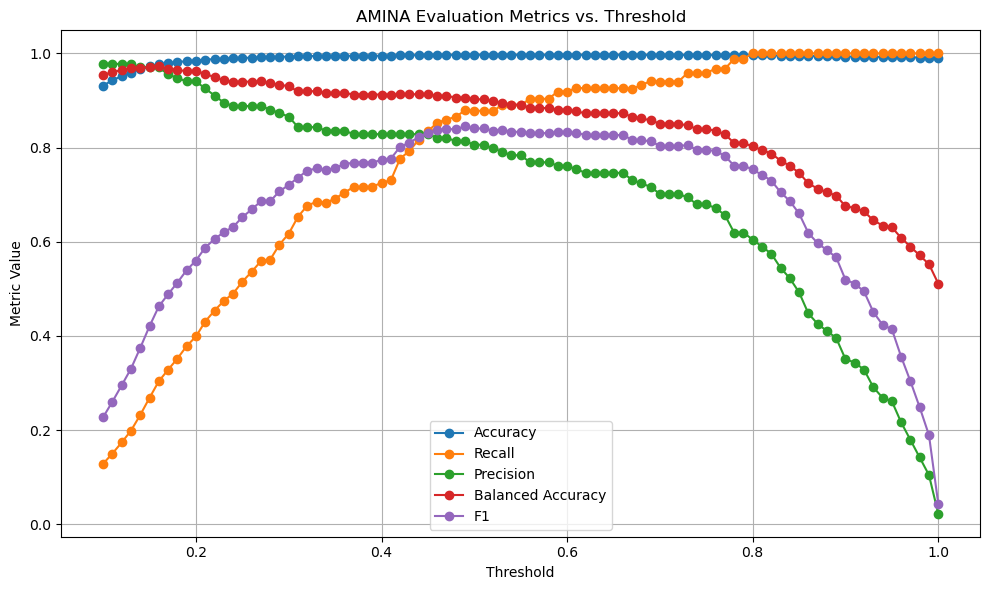



+----------------------+------------------+----------------+----------+---------+----------+---------+------------+--------+----------+-------------------+-------------------+
| Optimizing for:      | Dataset          | Threshold      | TP       |FP       | TN       |FN       |Accuracy    | Recall | Precision| Balanced Accuracy |      F1 score     |
+----------------------+------------------+----------------+----------+---------+----------+---------+------------+--------+----------+-------------------+-------------------+
| accuracy             | AMINA            | 0.49           | 109      | 25      | 12851    | 15      | 1.00       | 0.88   | 0.81     | 0.906133          | 0.844961          |
| balanced_accuracy    | AMINA            | 0.16           | 130      | 4       | 12568    | 298     | 0.98       | 0.30   | 0.97     | 0.973494          | 0.462633          |
| f1                   | AMINA            | 0.49           | 109      | 25      | 12851    | 15      | 1.00       | 0.

In [146]:
import json 
import os
import time

# Datasets folders 
datasets = ["AMINA"]

# "BTHS", "Mozilla", "HealthWatcher"
summary_table = pd.DataFrame(columns=["Dataset", "Accuracy"])

# For every dataset find the following:
for dataset in datasets:    
    req_path = f'../data/{dataset}/RE.csv'
    test_path = f'../data/{dataset}/ST.csv'
    ground_truth_mapping_path = f'../data/{dataset}/mapping.csv'

    print(f"Dataset: {dataset}")
    
    # Load and process data
    req_df, test_df, req_texts, test_texts = load_and_process(req_path, test_path)
    
    # Find cosine similarity and measure execution time
    start = time.time()

    metric_dict = [
        "accuracy",
        "recall",
        "precision",
        "balanced_accuracy",
        "f1"
    ]

    for param in metric_dict:
        print("*********************************************")
        print(f"OPTIMIZING FOR: {param}")
        print("*********************************************")
        predicted, threshold, threshold_values, accuracy_values, recall_values, precision_values, balanced_accuracy_values, f1_values = compute_cosine(req_df, test_df, req_texts, test_texts, ground_truth_mapping_path, test_path, param)
        t = time.time() - start
        
        # ***************************************************
        # Analyzing results (accuracy + visual comparison)
        # ***************************************************
        # Print results side by side 
        # print_side_by_side(predicted, ground_truth_mapping_path)

        # Compute accuracy
        tp, fp, tn, fn, accuracy, recall, precision, balanced_accuracy, f1 = calculate_accuracy(predicted, ground_truth_mapping_path, test_path, debug=False)
        
        print(f" SUMMARYYYYYYYYY Threshold: {threshold:.2f}, TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
        summary_table = pd.concat([
            summary_table,
            pd.DataFrame([{"Param": param, "Dataset": dataset, "Threshold": f"{threshold:.2f}", "TP": tp, "FP": fp, "TN": tn, "FN": fn, "Accuracy": accuracy, "Recall": recall, "Precision": precision, "Balanced Accuracy": balanced_accuracy, "F1 score": f1}])
        ], ignore_index=True)


    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(threshold_values, accuracy_values, label='Accuracy', marker='o')
    plt.plot(threshold_values, recall_values, label='Recall', marker='o')
    plt.plot(threshold_values, precision_values, label='Precision', marker='o')
    plt.plot(threshold_values, balanced_accuracy_values, label='Balanced Accuracy', marker='o')
    plt.plot(threshold_values, f1_values, label='F1', marker='o')

    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.title(f'{dataset} Evaluation Metrics vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    payload: dict[str, dict] = {
        "meta": {
            "req_path": req_path,
            "test_path": test_path,
            "mapping_path": ground_truth_mapping_path
        },
        "data": {
            "links": predicted,
            "time-to-analyze": t
        }
    }
    log_dir: str = f"./{dataset}"
    os.makedirs(log_dir, exist_ok=True)

    with open(f"{log_dir}/res.json", "w+") as out:
        json.dump(payload, out, indent=2)


print("\n")

# Print Final Results Table
print("+----------------------+------------------+----------------+----------+---------+----------+---------+------------+--------+----------+-------------------+-------------------+")
print("| Optimizing for:      | Dataset          | Threshold      | TP       |FP       | TN       |FN       |Accuracy    | Recall | Precision| Balanced Accuracy |      F1 score     |")
print("+----------------------+------------------+----------------+----------+---------+----------+---------+------------+--------+----------+-------------------+-------------------+")

summary_table = summary_table.sort_values(by='Param')

for _, row in summary_table.iterrows():
    print(f"| {row['Param']:<20} "
        f"| {row['Dataset']:<16} "
        f"| {row['Threshold']:<14} "
        f"| {int(row['TP']):<8} "
        f"| {int(row['FP']):<7} "
        f"| {int(row['TN']):<8} "
        f"| {int(row['FN']):<7} "
        f"| {row['Accuracy']:<10.2f} "
        f"| {row['Recall']:<6.2f} "
        f"| {row['Precision']:<8.2f} "
        f"| {row['Balanced Accuracy']:<18f}"
        f"| {row['F1 score']:<18f}|")
print("+----------------------+------------------+----------------+----------+---------+----------+---------+------------+--------+----------+-------------------+-------------------+")

summary_table.to_csv("summary_table.csv", index=False)